We thought that finding the co-occurrences of words in the review with negative or positive words from the corpus would be a good way to find out exactly which parts of the purchased product make it good or bad. For example, in a hot sauce review, it would be helpful for manufacturers and consumers alike to understand if it's the flavor, packaging, or something else that make it popular or unpopular. We could use this both to be able to predict the number of stars that an Amazon review will recieve and to indicate to customers what the best parts of a product are.

In [1]:
import nltk
import pickle
import random

with open('training_dicts.txt', 'rb') as file:
    lemmedreviews = pickle.load(file)
    
#make lists for each class in training set 
one_star = lemmedreviews[1]
two_star = lemmedreviews[2]
three_star = lemmedreviews[3]
four_star = lemmedreviews[4]
five_star = lemmedreviews[5]

In [2]:
#find co-occurences 
from collections import Counter

def find_cooccs(lst):
    span = 3
    cooccs_stem_surface = Counter()

    for sentence in lst:
        for i,w in enumerate(sentence):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(sentence)))) 
            for cw in [sentence[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_stem_surface:
                    cooccs_stem_surface[(w, cw)] += 1
    
    print(cooccs_stem_surface.most_common(10))
    return cooccs_stem_surface 

#apply to every class 
one_cooccs = find_cooccs(one_star)
two_cooccs = find_cooccs(two_star)
three_cooccs = find_cooccs(three_star)
four_cooccs = find_cooccs(four_star)
five_cooccs = find_cooccs(five_star)

[(('taste-NOUN', 'like-ADP'), 90), (('would-VERB', 'not-NEGATION'), 58), (('not-NEGATION', 'product-NOUN'), 58), (('like-ADP', 'not-NEGATION'), 58), (('taste-NOUN', 'not-NEGATION'), 51), (('not-NEGATION', 'even-ADV'), 39), (('not-NEGATION', 'buy-VERB'), 36), (('not-NEGATION', 'say-VERB'), 27), (('not-NEGATION', 'good-ADJ'), 26), (('one-NUM', 'not-NEGATION'), 25)]
[(('like-ADP', 'taste-NOUN'), 63), (('like-ADP', 'not-NEGATION'), 58), (('not-NEGATION', 'taste-NOUN'), 50), (('coffee-NOUN', 'like-ADP'), 37), (('would-VERB', 'not-NEGATION'), 36), (('not-NEGATION', 'good-ADJ'), 34), (('not-NEGATION', 'product-NOUN'), 27), (('really-ADV', 'like-ADP'), 24), (('not-NEGATION', 'try-VERB'), 22), (('not-NEGATION', 'much-ADJ'), 22)]
[(('taste-NOUN', 'like-ADP'), 86), (('not-NEGATION', 'would-VERB'), 75), (('taste-NOUN', 'not-NEGATION'), 68), (('not-NEGATION', 'like-ADP'), 64), (('good-ADJ', 'not-NEGATION'), 56), (('coffee-NOUN', 'not-NEGATION'), 56), (('not-NEGATION', 'really-ADV'), 48), (('one-NUM

Find the most "polarized" combinations of words per class

In [ ]:
#perform sentiment analysis
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn 
import operator 
import collections

#create mapping for proper sentiment analysis 
mapping = {'NOUN':wn.NOUN, "ADJ": wn.ADJ, 'VERB' : wn.VERB, "ADV": wn.ADV}

def find_vals(lst):
    #make synsets out of tuples
    list_cooccs = lst
    word1, word2 = "", ""
    positive_score, negative_score, positive_score2, negative_score2 = 0,0,0,0
    #dictionary to store tuples of co-occurences and their positivity 
    wordvals = {}

    #give items new mapping for use with senti_synsets
    for tup in list_cooccs:
        #get individual words out of tuple
        w1 = tup[0].split("-")
        w2 = tup[1].split("-")
    
        #check if first word in tuple is contained within mapping
        if w1[1] in mapping.keys() and mapping[w1[1]] == 'a':
            #extract part of speech
            one_pos = mapping[w1[1]]
            #extract the word itself 
            word1 = w1[0]
        
            #test that synsets exist 
            if len(list(swn.senti_synsets(word1, pos = one_pos))) > 0:
                scores = swn.senti_synset(word1 + "."+ one_pos + ".01")
                #calculate positive and negative scores for word 1 
                positive_score = scores.pos_score()
                negative_score = scores.neg_score()
            
        #repeat for second word in tuple         
        if w2[1] in mapping.keys() and mapping[w2[1]] == 'n':
            #extract part of speech 
            two_pos = mapping[w2[1]]
            word2 = w2[0]
        
            if len(list(swn.senti_synsets(word2, pos = two_pos))) > 0:
                scores2 = swn.senti_synset(word2 + "."+ two_pos + ".01")
                #calculate positive and negative scores for word 1 
                positive_score2 = scores2.pos_score()
                negative_score2 = scores2.neg_score() 
            
        #store tuples and positivity values in a dictionary
        tupl = (word1, word2)
        wordvals[tupl] = (positive_score + negative_score + positive_score2 + negative_score2)

    #sort the dictionary of positive and negative values from largest to smallest 
    sorted_wordvals = list(reversed(sorted(wordvals.items(), key=operator.itemgetter(1))))
    #sorted_dict = collections.OrderedDict(reversed(sorted_wordvals))
    return sorted_wordvals

one_vals = find_vals(one_cooccs)
two_vals = find_vals(two_cooccs)
three_vals = find_vals(three_cooccs)
four_vals = find_vals(four_cooccs)
five_vals = find_vals(five_cooccs)


In [ ]:
print(one_vals[10:20])
print(two_vals[10:20])
print(three_vals[10:20])
print(four_vals[10:20])
print(five_vals[10:20])

We're going to find the PLMI of the co-occurences per class to use as a feature for classification 

In [7]:
#plmi measure
from itertools import chain
from math import log


def ppmi(o_11, r_1, c_1, n):
    """
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    PMI is also available in NLTK:
    from nltk.metrics import BigramAssocMeasures
    print BigramAssocMeasures.pmi(8, (15828, 4675), 14307668)
    """
    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)

def plmi(o_11, r_1, c_1, n):
    """
    Positive Local Mutual Information, useful for leveraging the 
    low-frequency bias of the PPMI
    """
    res = o_11 * ppmi(o_11, r_1, c_1, n)
    return res

def find_plmi(cooccs_dict, lst):
    N = len(cooccs_dict.values())
    plmis_lem_surface = Counter()
    lem_frequencies = Counter(chain(*lst))

    print(lem_frequencies)
    for k,v in cooccs_dict.items():
        plmis_lem_surface[k] = plmi(v, lem_frequencies[k[0]], lem_frequencies[k[1]], N)

    print(plmis_lem_surface.most_common(10))
    return plmis_lem_surface

In [8]:
one_plmi = find_plmi(one_cooccs, one_star)
#two_plmi =  find_plmi(two_cooccs, two_star)
#three_plmi = find_plmi(three_cooccs, three_star)
#four_plmi = find_plmi(four_cooccs, four_star)
#five_plmi = find_plmi(five_cooccs, five_star)

Counter({'not-NEGATION': 697, 'like-ADP': 373, 'taste-NOUN': 263, 'would-VERB': 253, 'product-NOUN': 246, 'get-VERB': 245, 'make-VERB': 223, 'one-NUM': 215, 'no-NEGATION': 192, 'coffee-NOUN': 186, 'even-ADV': 172, 'try-VERB': 169, 'food-NOUN': 166, 'go-VERB': 150, 'buy-VERB': 144, 'give-VERB': 132, 'good-ADJ': 130, 'know-VERB': 118, 'bad-ADJ': 116, 'flavor-NOUN': 116, 'say-VERB': 113, 'cup-NOUN': 112, 'time-NOUN': 112, 'bought-NOUN': 112, 'use-VERB': 108, 'amazon-NOUN': 108, 'really-ADV': 106, 'box-NOUN': 104, 'bag-NOUN': 99, 'well-ADV': 91, 'come-VERB': 90, 'order-VERB': 88, 'dog-NOUN': 87, 'chip-NOUN': 87, 'thought-NOUN': 85, 'review-NOUN': 84, 'much-ADJ': 83, 'receive-VERB': 81, 'first-ADV': 81, 'cat-NOUN': 81, 'eat-NOUN': 81, 'love-NOUN': 80, 'taste-VERB': 78, 'order-NOUN': 78, 'also-ADV': 78, 'chocolate-NOUN': 77, 'take-VERB': 75, 'two-NUM': 74, 'try-NOUN': 73, 'water-NOUN': 73, 'tea-NOUN': 72, 'never-ADV': 71, 'item-NOUN': 70, 'could-VERB': 70, 'way-NOUN': 68, 'think-NOUN': 68, '

We can also use the average positivity and negativity of each class to use as features as well.

In [9]:
#find average positivity + negativity for each word in each class 
def find_senti(lst):
    avg_review = []
    for sublist in lst:
        avg_positivity, avg_negativity, total_words = 0, 0, 0
        #find total num words in each class for calculating the average
        total_words = len(sublist)
        for word in sublist:
            #split item into individual word and lemma 
            trunc_word = word.split("-")
            #TODO: handle negation!! this is a band-aid  
            if trunc_word[1] not in mapping:
                continue
            #get the right part of speech from predefined mapping
            new_pos = mapping[trunc_word[1]]
            if len(list(swn.senti_synsets(trunc_word[0], pos = new_pos))) > 0:
                scores = swn.senti_synset(trunc_word[0] + "."+ new_pos + ".01")
                #find senti-wordnet's positivity and negativity rating for each word in each class  
                avg_positivity += scores.pos_score()
                avg_negativity += scores.neg_score() 
        avg_tupl = ((avg_positivity/total_words), (avg_negativity/total_words))
        avg_review.append(avg_tupl)
                
                

    return avg_review

In [10]:
one_senti = find_senti(one_star)
two_senti = find_senti(two_star)
three_senti = find_senti(three_star)
four_senti = find_senti(four_star)
five_senti = find_senti(five_star)


In [11]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns

# Lists of the average respectively positivity and negativity scores
# Deleted the zeroes from the negative scores otherwise there are 
# weird peaks
one_avg_pos = [avg_pos for avg_pos, avg_neg in one_senti] 
one_avg_neg = [avg_neg for avg_pos, avg_neg in one_senti] 
two_avg_pos = [avg_pos for avg_pos, avg_neg in two_senti] 
two_avg_neg = [avg_neg for avg_pos, avg_neg in two_senti] 
three_avg_pos = [avg_pos for avg_pos, avg_neg in three_senti] 
three_avg_neg = [avg_neg for avg_pos, avg_neg in three_senti] 
four_avg_pos = [avg_pos for avg_pos, avg_neg in four_senti] 
four_avg_neg = [avg_neg for avg_pos, avg_neg in four_senti] 
five_avg_pos = [avg_pos for avg_pos, avg_neg in five_senti] 
five_avg_neg = [avg_neg for avg_pos, avg_neg in five_senti] 


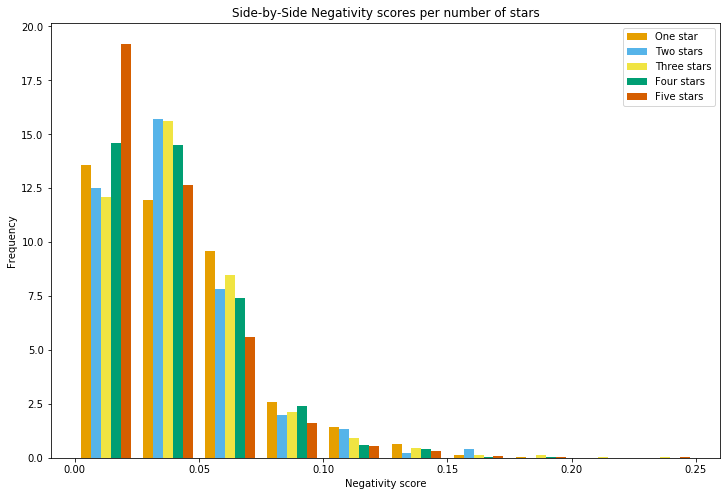

In [12]:
figsize(12,8)
#Assign colors to each score
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars']
plt.hist([one_avg_neg, two_avg_neg, three_avg_neg, four_avg_neg, five_avg_neg], 
         bins = 10, color=colors, label=names, density=True)

plt.legend()
plt.xlabel('Negativity score')
plt.ylabel('Frequency')
plt.title('Side-by-Side Negativity scores per number of stars')
plt.show()

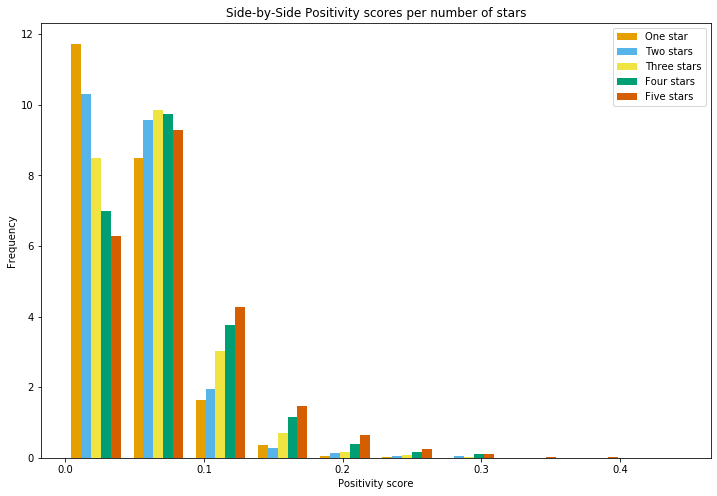

In [13]:

figsize(12,8)
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars']
plt.hist([one_avg_pos, two_avg_pos, three_avg_pos, four_avg_pos, five_avg_pos], 
         bins = 10, color=colors, label=names, density=True)

plt.legend()
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title('Side-by-Side Positivity scores per number of stars')
plt.show()

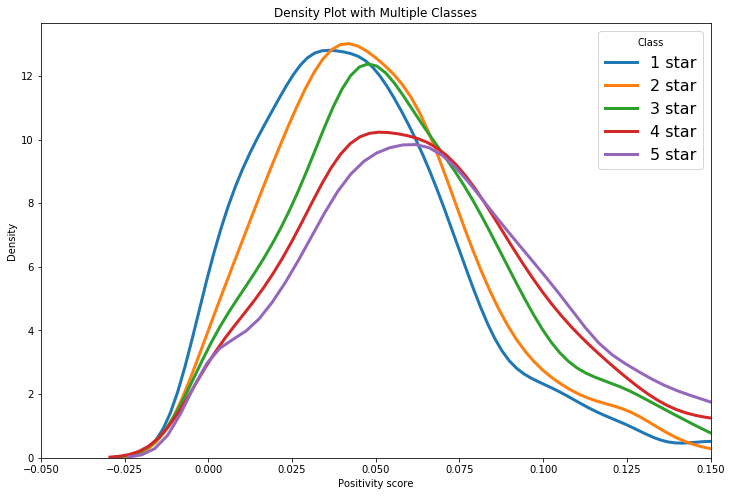

In [14]:
pos_list = [one_avg_pos, two_avg_pos, three_avg_pos, four_avg_pos, five_avg_pos]
fig, ax = plt.subplots()
for pos in pos_list:
    sns.distplot(pos, hist = False, kde = True, 
                 kde_kws = {'linewidth':3}, 
                 label = str(pos_list.index(pos)+1)+' star')
ax.set_xlim(-0.05,0.15)

    
plt.legend(prop={'size': 16}, title = 'Class')
plt.title('Density Plot with Multiple Classes'); 
plt.xlabel('Positivity score')
plt.ylabel('Density');
plt.show()

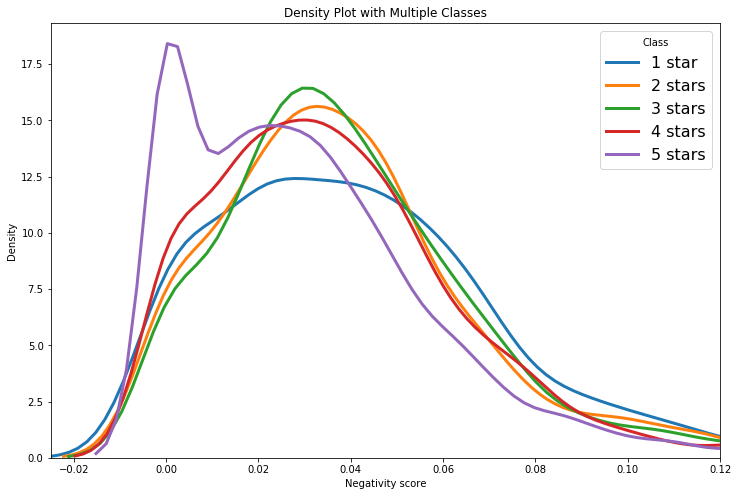

In [15]:
neg_list = [one_avg_neg, two_avg_neg, three_avg_neg, four_avg_neg, five_avg_neg]
fig, ax = plt.subplots()


def labels(index):
    num = index + 1
    if num > 1:
        return str(num) + ' stars'
    else: 
        return '1 star'

for neg in neg_list:
    sns.distplot(neg, hist = False, kde = True, 
                 kde_kws = {'linewidth':3}, 
                 label = labels(neg_list.index(neg)))

ax.set_xlim(-0.025,0.12)


plt.legend(prop={'size': 16}, title = 'Class')
plt.title('Density Plot with Multiple Classes')
plt.xlabel('Negativity score')
plt.ylabel('Density')
plt.show()

For this section, we want to find the noun that co-occurs with the most polar words in a review to be indicative of the best quality of a product. This is not a feature for our classifier, but rather something that would be interesting to a manufacturer or a user. It finds the nouns in a review and the words it co-occurs with in a 3-word span. It then finds the polarity of the words in the span and chooses the noun with the co-occurring words with the highest polarity. In this context, polarity is defined as the sum of a word's positivity and negativity scores. 

In [5]:
with open('cooccs_dict.txt', 'rb') as file:
    cooccs_dict = pickle.load(file)
    
print(cooccs_dict)

{'B0002TJAZK': (3, ['food-NOUN', 'work-VERB', 'well-ADV', 'kidney-NOUN', 'find-VERB', 'info-NOUN', 'many-ADJ', 'can-NOUN', 'include-VERB', 'guess-VERB', 'can-NOUN', 'base-VERB', 'shipping-NOUN', 'weight-NOUN', 'buy-VERB', 'without-ADP', 'well-ADV']), 'B0016PKA1C': (3, ['get-VERB', 'one-NUM', 'honest-NOUN', 'work-NOUN', 'well-ADV', 'extend-NOUN', 'life-NOUN', 'fresh-ADJ', 'herb-NOUN', 'provide-VERB', 'attractive-ADJ', 'main-ADJ', 'problem-NOUN', 'container-NOUN', 'difficult-ADJ', 'get-VERB', 'easy-ADJ', 'time-NOUN', 'whoever-NOUN', 'design-VERB', 'thing-NOUN', 'not-NEGATION', 'not-NEGATION', 'make-VERB', 'hard-ADJ', 'get-VERB', 'thing-NOUN', 'easy-ADJ', 'open-ADJ', 'nothing-NOUN', 'inside-ADP', 'use-NOUN', 'much-ADJ', 'force-NOUN', 'need-VERB', 'open-ADJ', 'need-NOUN', 'open-ADJ', 'squeeze-NOUN', 'side-NOUN', 'pull-NOUN', 'plastic-NOUN', 'cover-NOUN', 'break-NOUN', 'pretty-ADV', 'sturdy-NOUN', 'real-ADJ', 'issue-NOUN', 'fill-VERB', 'water-NOUN', 'difficult-ADJ', 'use-NOUN', 'much-ADJ', 

In [114]:
def analyze_review(lst):
    span = 1
    impt_features = {}
    polarities = []
    
    #for review in lst:
    for i,w in enumerate(review):
        w1, w2 = w.split("-") 
        if w2 != 'NOUN':
            continue   
         #check all co-occurring words within a 3 word span 
        span_range = list(range(max(i- span, 0), i)) 
        span_range.extend(range(i+1, min(i + span + 1, len(review))))
        for cw in [review[idx] for idx in span_range]:
            cw1, cw2 = cw.split("-")
            if cw2 in mapping:
                #get the right part of speech from predefined mapping
                new_pos = mapping[cw2]
                if len(list(swn.senti_synsets(cw1, pos = new_pos))) > 0 and cw2 == "ADJ":
                    scores = swn.senti_synset(cw1 + "."+ new_pos + ".01")
                    #make polarity the sum of positivity and negativity
                    polarity = int(scores.pos_score() + scores.neg_score())
                    polarities.append(polarity)
                    #store co-occuring words with associated polarity in dict 
                    impt_features[polarity] = (cw, w1+"-"+w2)
                        
    #find the co-occurring words with the highest combined polarity score 
    highest_polarity = max(polarities, default=0)
    if highest_polarity in impt_features.keys():
        return impt_features[highest_polarity] 

In [119]:
#get list of all unique product ids 
product_ids = set(cooccs_dict.keys())

impt_features = []

#find important features about each product
for id in product_ids: 
    review = cooccs_dict[id][1]
    impt_features = analyze_review(review)

    print("The most important aspect about item " + str(id) + " with score " + str(cooccs_dict[id][0]) + " is: " 
         + str(impt_features))

The most important aspect about item B0004MZVIA with score 5 is: ('happy-ADJ', 'found-NOUN')
The most important aspect about item B001EO7JFU with score 4 is: ('delightful-ADJ', 'aroma-NOUN')
The most important aspect about item B00285FFCS with score 3 is: ('great-ADJ', 'chocolate-NOUN')
The most important aspect about item B001ESOQAM with score 4 is: ('great-ADJ', 'deal-NOUN')
The most important aspect about item B0075NJG3W with score 2 is: ('low-ADJ', 'star-NOUN')
The most important aspect about item B000SSQXG4 with score 3 is: ('small-ADJ', 'bit-NOUN')
The most important aspect about item B003MPKGKE with score 3 is: ('unacceptable-ADJ', 'day-NOUN')
The most important aspect about item B003AO5DLO with score 4 is: ('large-ADJ', 'bag-NOUN')
The most important aspect about item B000FAM3Z0 with score 5 is: ('best-ADJ', 'healther-NOUN')
The most important aspect about item B001E5E29A with score 5 is: ('great-ADJ', 'delivery-NOUN')
The most important aspect about item B006K2ZZ7K with score 

The most important aspect about item B0043H35N0 with score 5 is: ('free-ADJ', 'radical-NOUN')
The most important aspect about item B003JNWQPC with score 1 is: None
The most important aspect about item B001SAXWII with score 4 is: ('nice-ADJ', 'sweet-NOUN')
The most important aspect about item B0007T3V82 with score 5 is: ('good-ADJ', 'hit-NOUN')
The most important aspect about item B000ELWDR8 with score 5 is: ('french-ADJ', 'onion-NOUN')
The most important aspect about item B000P151AI with score 5 is: ('fresh-ADJ', 'quality-NOUN')
The most important aspect about item B000FL08PG with score 5 is: ('great-ADJ', 'coffee-NOUN')
The most important aspect about item B001EPPI84 with score 2 is: None
The most important aspect about item B0076ZJ21K with score 5 is: ('great-ADJ', 'purchase-NOUN')
The most important aspect about item B001EO67V2 with score 4 is: ('good-ADJ', 'flavor-NOUN')
The most important aspect about item B00769ZSVO with score 5 is: ('little-ADJ', 'guy-NOUN')
The most important a

The most important aspect about item B005ATI9EU with score 2 is: ('good-ADJ', 'combination-NOUN')
The most important aspect about item B000084EKB with score 4 is: ('little-ADJ', 'richer-NOUN')
The most important aspect about item B000P5IWYG with score 5 is: None
The most important aspect about item B003ZRHYU4 with score 5 is: ('similar-ADJ', 'taste-NOUN')
The most important aspect about item B004ALGNQ0 with score 5 is: None
The most important aspect about item B000633O2C with score 5 is: ('healthy-ADJ', 'food-NOUN')
The most important aspect about item B005K4Q1VI with score 3 is: ('hot-ADJ', 'water-NOUN')
The most important aspect about item B003XV5LHK with score 5 is: ('double-ADJ', 'stuff-NOUN')
The most important aspect about item B001PKUXRE with score 5 is: None
The most important aspect about item B001EPPCNK with score 5 is: ('bavarian-ADJ', 'creme-NOUN')
The most important aspect about item B0009JI7O8 with score 4 is: ('good-ADJ', 'picky-NOUN')
The most important aspect about ite

The most important aspect about item B004G8ZAS4 with score 3 is: ('independent-ADJ', 'support-NOUN')
The most important aspect about item B009AVDFCK with score 5 is: ('great-ADJ', 'gift-NOUN')
The most important aspect about item B0048IAKP0 with score 5 is: ('great-ADJ', 'sailsbury-NOUN')
The most important aspect about item B005IZO3A0 with score 1 is: ('second-ADJ', 'bite-NOUN')
The most important aspect about item B00094HIZC with score 5 is: ('healthy-ADJ', 'alternative-NOUN')
The most important aspect about item B0060AOSGG with score 5 is: ('big-ADJ', 'problem-NOUN')
The most important aspect about item B0025UOODW with score 5 is: ('much-ADJ', 'richer-NOUN')
The most important aspect about item B00734W80Q with score 4 is: ('mixed-ADJ', 'excellent-NOUN')
The most important aspect about item B001QZW13W with score 5 is: ('rich-ADJ', 'chocolate-NOUN')
The most important aspect about item B003YEX696 with score 5 is: ('great-ADJ', 'price-NOUN')
The most important aspect about item B000084

The most important aspect about item B000CS9ZTC with score 2 is: ('regular-ADJ', 'price-NOUN')
The most important aspect about item B007TFONH0 with score 5 is: ('great-ADJ', 'forget-NOUN')
The most important aspect about item B007P2PSKS with score 3 is: ('enjoyable-ADJ', 'price-NOUN')
The most important aspect about item B000EUC8EC with score 5 is: ('good-ADJ', 'coat-NOUN')
The most important aspect about item B001LDOFJ2 with score 3 is: ('big-ADJ', 'box-NOUN')
The most important aspect about item B0007OVXSC with score 5 is: None
The most important aspect about item B004QXELMK with score 5 is: ('large-ADJ', 'chocolate-NOUN')
The most important aspect about item B0017WFN4S with score 5 is: ('special-ADJ', 'think-NOUN')
The most important aspect about item B00473VNHK with score 5 is: ('good-ADJ', 'condition-NOUN')
The most important aspect about item B003Y86ONM with score 1 is: ('next-ADJ', 'month-NOUN')
The most important aspect about item B0025Z7CGI with score 5 is: ('great-ADJ', 'job-

The most important aspect about item B000N5XCPM with score 5 is: ('real-ADJ', 'chunk-NOUN')
The most important aspect about item B0041HNGGS with score 5 is: ('edible-ADJ', 'chemistry-NOUN')
The most important aspect about item B000143ZKM with score 5 is: ('young-ADJ', 'recommend-NOUN')
The most important aspect about item B005O072PC with score 5 is: ('little-ADJ', 'need-NOUN')
The most important aspect about item B001IZM8A6 with score 5 is: ('main-ADJ', 'entree-NOUN')
The most important aspect about item B004ET9OIW with score 2 is: ('happy-ADJ', 'baby-NOUN')
The most important aspect about item B001EW5YQS with score 1 is: ('true-ADJ', 'plug-NOUN')
The most important aspect about item B003FA0M1O with score 3 is: ('certain-ADJ', 'pin-NOUN')
The most important aspect about item B0000V1B4I with score 5 is: ('good-ADJ', 'stuff-NOUN')
The most important aspect about item B002Y2WM62 with score 5 is: ('great-ADJ', 'treat-NOUN')
The most important aspect about item B001YJ6M7Q with score 5 is: (

The most important aspect about item B006JGFYY6 with score 2 is: ('much-ADJ', 'flavor-NOUN')
The most important aspect about item B000G6RPMY with score 4 is: ('important-ADJ', 'wash-NOUN')
The most important aspect about item B004M1O1JE with score 5 is: ('much-ADJ', 'spicy-NOUN')
The most important aspect about item B0006NEDWC with score 4 is: None
The most important aspect about item B0019DCU50 with score 5 is: ('superior-ADJ', 'chamomile-NOUN')
The most important aspect about item B000CQG862 with score 5 is: ('little-ADJ', 'brisk-NOUN')
The most important aspect about item B005Y0DXBO with score 5 is: ('high-ADJ', 'stock-NOUN')
The most important aspect about item B000A3TVBQ with score 2 is: ('nice-ADJ', 'level-NOUN')
The most important aspect about item B003SBZF1W with score 5 is: ('organic-ADJ', 'juice-NOUN')
The most important aspect about item B002BRC562 with score 5 is: ('easy-ADJ', 'stomach-NOUN')
The most important aspect about item B002SWR5VK with score 5 is: ('best-ADJ', 'kar

The most important aspect about item B000LKYVZE with score 5 is: ('tiny-ADJ', 'insect-NOUN')
The most important aspect about item B0005ZWN0A with score 4 is: ('oriental-ADJ', 'flavor-NOUN')
The most important aspect about item B002BB7EWI with score 5 is: ('fresh-ADJ', 'banana-NOUN')
The most important aspect about item B001HTN94C with score 4 is: ('strong-ADJ', 'taste-NOUN')
The most important aspect about item B0041T6KT6 with score 5 is: ('willing-ADJ', 'order-NOUN')
The most important aspect about item B007VXSSOE with score 5 is: ('best-ADJ', 'sauce-NOUN')
The most important aspect about item B003ZT61QK with score 5 is: ('available-ADJ', 'become-NOUN')
The most important aspect about item B0014157CA with score 5 is: None
The most important aspect about item B008YGWIZM with score 5 is: ('great-ADJ', 'change-NOUN')
The most important aspect about item B005OE12MM with score 5 is: None
The most important aspect about item B0002Q1X6C with score 1 is: None
The most important aspect about i

The most important aspect about item B004NE2E9O with score 5 is: ('great-ADJ', 'hope-NOUN')
The most important aspect about item B000UJG79Y with score 1 is: ('much-ADJ', 'cleaner-NOUN')
The most important aspect about item B004RDNGSY with score 1 is: None
The most important aspect about item B004QK5J8S with score 1 is: ('strong-ADJ', 'skin-NOUN')
The most important aspect about item B000FDKQCY with score 5 is: ('second-ADJ', 'bread-NOUN')
The most important aspect about item B0009JMW1C with score 4 is: ('little-ADJ', 'sinus-NOUN')
The most important aspect about item B001HTR4WA with score 5 is: ('organic-ADJ', 'quality-NOUN')
The most important aspect about item B001FWXLX0 with score 5 is: ('fresh-ADJ', 'bowl-NOUN')
The most important aspect about item B0025VQGHS with score 5 is: ('fresh-ADJ', 'cottonelle-NOUN')
The most important aspect about item B0039OGMWE with score 5 is: None
The most important aspect about item B004N5KTOK with score 5 is: ('good-ADJ', 'shape-NOUN')
The most impor

In [117]:
one_properties = analyze_review(one_star)
two_properties = analyze_review(two_star)
three_properties = analyze_review(three_star)
four_properties = analyze_review(four_star)
five_properties = analyze_review(five_star)

In [69]:
#find the largest key (aka most polar item) in dictionary
print(one_properties[max(one_properties, key=one_properties.get)])


#track = {}
#for key,value in five_properties.items():
 ##      track[value]=0
    #else:
   #     track[value]+=1

#print(max(track,key=track.get))


('impressed-ADJ', 'cooky-NOUN')


In [ ]:
#TODO: plot the most common polar items 